In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import boto3
from botocore.client import Config
import os
import pandas as pd
from io import StringIO
import matplotlib.dates as dates
from datetime import datetime
import matplotlib.ticker as ticker
from random import shuffle
from time import time
from pandas.plotting import register_matplotlib_converters
%matplotlib notebook

os.chdir('C:\\Users\\A Sua\\Documents\\AWS\\credentials')
list_of_lines = []
with open('capstoner_key.txt') as fp:
    lines = fp.readlines()
    for line in lines:
        line = line.strip()
        list_of_lines.append(line)
    fp.close()


location = list_of_lines[0].split('=')[1]
AWS_ACCESS_KEY_ID = list_of_lines[1].split('=')[1]
AWS_SECRET_ACCESS_KEY = list_of_lines[2].split('=')[1]
os.chdir('C:\\Users\\A Sua\\Documents\\FIU\\CAP2020')

In [3]:
register_matplotlib_converters()
%matplotlib notebook

### import dataframes

In [4]:
df_name_list = ['df_bidlo07_18', 'df_returns07_18', 'df_spread07_18', 'df_price07_18']
df_list = []

In [5]:
### BUCKETS & KEYS
BUCKET_NAME = 'capstonefiu2020-data'
key_location = 'data/processed'

### ACTIVATE CLIENT
client = boto3.client('s3', 
              aws_access_key_id = AWS_ACCESS_KEY_ID,
               aws_secret_access_key=AWS_SECRET_ACCESS_KEY)


for name in df_name_list:
    file_name = '{}.csv'.format(name)
    key_path = key_location + '/' + file_name

    ### INSTANTIATE DATAFRAME
    csv_obj = client.get_object(Bucket = BUCKET_NAME, Key=key_path)
    body = csv_obj['Body']
    csv_string = body.read().decode('utf-8')

    temp_df = pd.read_csv(StringIO(csv_string))
    temp_df.index = temp_df['Unnamed: 0']
    temp_df = temp_df.drop('Unnamed: 0', axis=1)
    temp_df.index.names = ['date']


    #df_bidlo.head()
    #### TRANSPOSE DATA FOR EASE OF USE
    temp_df = temp_df.T
    temp_df.index = pd.to_datetime(temp_df.index)
    df_list.append(temp_df)
    print('{} added to df_list'.format(name))

df_bidlo07_18 added to df_list
df_returns07_18 added to df_list
df_spread07_18 added to df_list
df_price07_18 added to df_list


In [6]:
df_bidlo = df_list[0]
df_returns = df_list[1]
df_spread = df_list[2]
df_price = df_list[3]

In [8]:
df_bs = df_price -df_bidlo + 1e-70
df_bss = df_bs/df_spread

In [9]:
df_price.columns[:5]

Index(['ORCL_ORACLE CORP', 'MSFT_MICROSOFT CORP',
       'TROW_T ROWE PRICE GROUP INC', 'HON_HONEYWELL INTERNATIONAL INC',
       'ADM_ARCHER DANIELS MIDLAND CO'],
      dtype='object', name='date')

In [12]:
symbol = 'ORCL_ORACLE CORP'

temp_series = df_returns[symbol]
temp_series = temp_series[np.abs(temp_series)>0.01]
temp_series

2007-01-03    0.021587
2007-01-08    0.012472
2007-01-11   -0.021384
2007-01-16   -0.011429
2007-01-17    0.012717
                ...   
2018-12-17   -0.018670
2018-12-19    0.013086
2018-12-21   -0.048443
2018-12-24   -0.029773
2018-12-26    0.044507
Name: ORCL_ORACLE CORP, Length: 1296, dtype: float64

### Create the dictionary of Positive (>0.01) and Negative (<-0.01) returns for each stock

In [33]:
high_returns = {}
low_returns = {}

for symbol in df_returns.columns:
    temp_series = df_returns[symbol]
    temp_series_high = temp_series[temp_series>0.01]
    temp_series_low = temp_series[temp_series<=-0.01]    
    high_returns[symbol] = temp_series_high
    low_returns[symbol] = temp_series_low


print(len(high_returns), len(low_returns))    
print(len(high_returns['ORCL_ORACLE CORP']), len(low_returns['ORCL_ORACLE CORP']))

388 388
690 606


### what are the dates of those returns? 

In [36]:
bss_high_returns = {}
bss_low_returns = {}
for symbol in df_returns.columns:
    temp_high = high_returns[symbol]
    temp_low = low_returns[symbol]
    
    temp_high = pd.merge(temp_high, df_bss[symbol], left_index=True, right_index=True, copy=False, suffixes=('_x', ''))[symbol]
    temp_low = pd.merge(temp_low, df_bss[symbol], left_index=True, right_index=True, copy=False, suffixes=('_x', ''))[symbol]
    
    bss_high_returns[symbol] = temp_high
    bss_low_returns[symbol] = temp_low

print(len(bss_high_returns['ADM_ARCHER DANIELS MIDLAND CO']), len(bss_low_returns['ADM_ARCHER DANIELS MIDLAND CO']))

722 648


### Dictionary of correlations

In [45]:
# cor_high = {}
# cor_low = {}
corrs = {}

for symbol in df_returns.columns:
    ret_high = high_returns[symbol]
    bss_high = bss_high_returns[symbol]

    ret_low = low_returns[symbol]
    bss_low = bss_low_returns[symbol]    
    
    temp_corr_high = np.corrcoef(ret_high, bss_high)[0, 1]
    temp_corr_low = np.corrcoef(ret_low, bss_low)[0, 1]    
    corrs[symbol] = [temp_corr_high, temp_corr_low]
    #cor_low[symbol] = [temp_corr_low, temp_corr_low]


corrs['ADM_ARCHER DANIELS MIDLAND CO']

C:\PROGRA1\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2449: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


[0.12092786762539169, 0.1538329259144263]









Batch 0


<IPython.core.display.Javascript object>


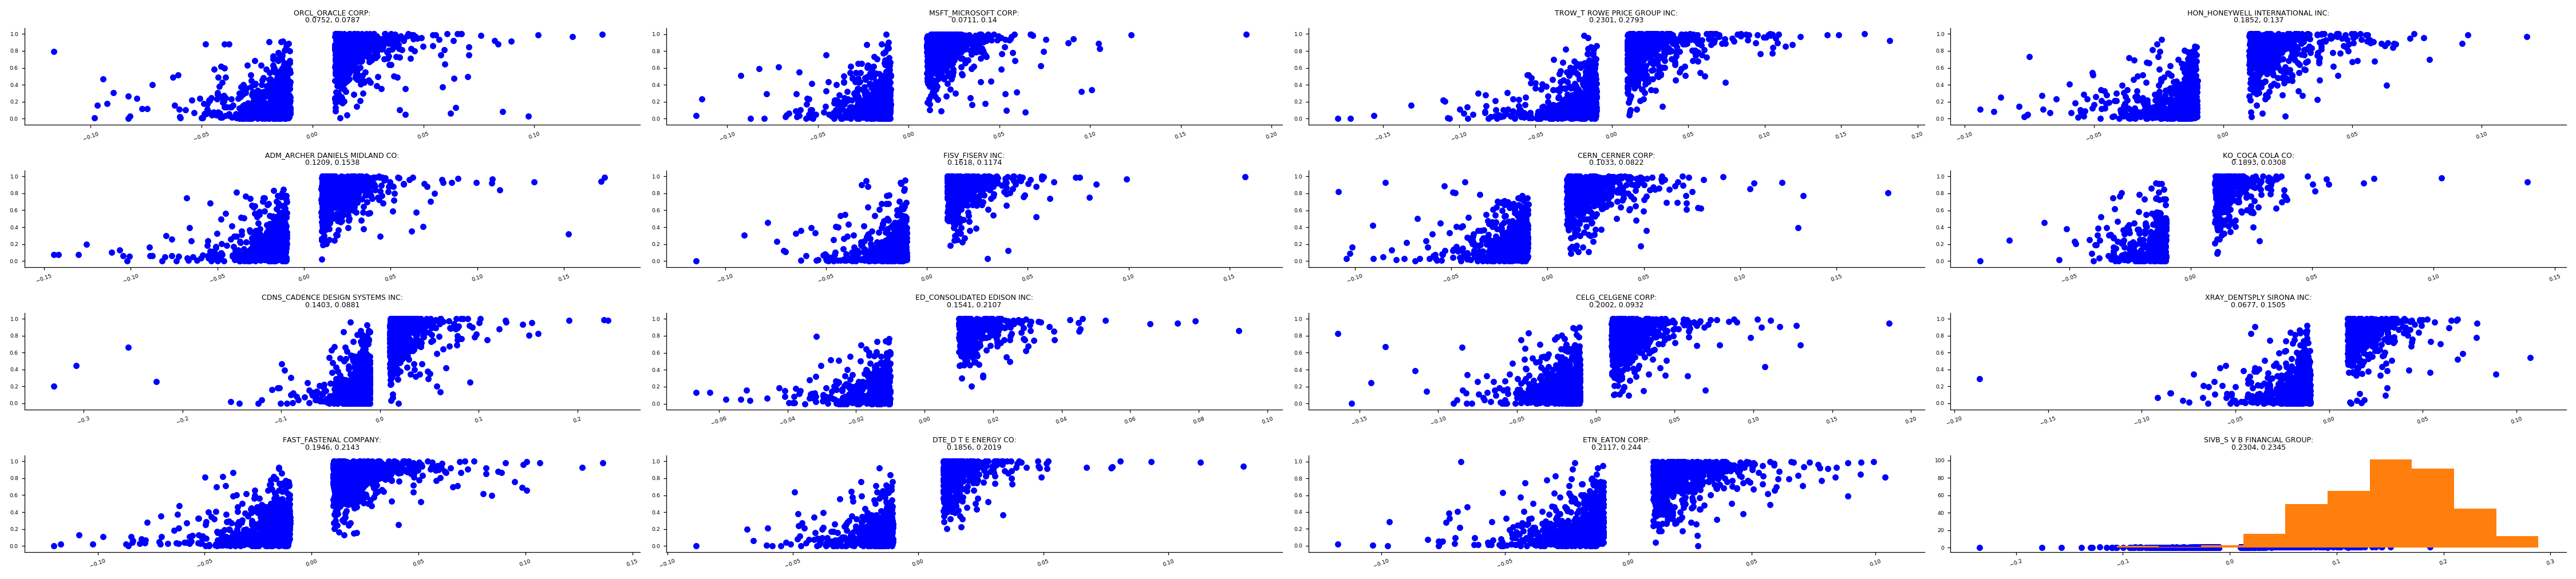

In [46]:
#sup_title_font =15
sub_title_font =10
title_font = 10
legend_font =8
axis_font = 8
tick_rotation = 20
black_dot = 2
red_dot = 5


### matrix of subplots
n_cols = 2
n_rows = 16
#n_plots = n_cols*n_rows
nloops = int(np.floor(388/n_rows))#sup_title_font =15
sub_title_font =8
legend_font =8
axis_font = 6
tick_rotation = 20
black_dot = 3
blue_dot = 1
red_dot = 5


### matrix of subplots
n_cols = 4
n_rows = 4
n_plots = n_cols*n_rows
nloops = int(np.floor(388/n_plots))
temp_matrix = np.array(range(n_plots)).reshape(n_rows,n_cols)

for i in range(nloops):
    nn = len(df_price.columns)
    lower = i*n_plots
    upper = (i+1)*n_plots
    #print(lower, upper)
    temp_list = df_price.columns[lower:upper]
    print('\n\n\n\n\n\n\n\nBatch {}'.format(i))
    
    
    ####----PLOT THE FIGURES---------#####
    
    ### instantiage
    fig, ax = plt.subplots(n_rows,n_cols,figsize=(40,9))
    for k in range(n_rows):
        for l in range(n_cols):
            ## indices
            temp_idx = temp_matrix[k,l]
            symbol = temp_list[temp_idx]
             
            temp_corr = corrs[symbol]
            temp_color = []
            for value in temp_corr:
                if value <= 0.4:
                    temp_color.append('blue')
                elif value <= 0.7: 
                    temp_color.append('yellow')
                else:
                    temp_color.append('red')
               
            ### PLOT: Low Correlations 
            wm = ax[k,l].scatter(high_returns[symbol], bss_high_returns[symbol], 
                       color=temp_color[0])             
            ### PLOT: High Correlations 
            wm = ax[k,l].scatter(low_returns[symbol], bss_low_returns[symbol], 
                       color=temp_color[1])             
            
            ax[k,l].spines['top'].set_visible(False)
            ax[k,l].spines['right'].set_visible(False)
            ax[k,l].set_title('{}:\n{}, {}'.format(symbol, round(corrs[symbol][0], 4), round(corrs[symbol][1], 4)), fontsize=sub_title_font) 
            #ax[k,l].set_xlabel(fontsize=x_axis_font)
            ax[k,l].tick_params(axis="x", labelsize=axis_font, rotation=tick_rotation)
            ax[k,l].tick_params(axis="y", labelsize=axis_font)
            #ax[k,l].set_ylim([0.7, 1.02])            
         
            
            
    #fig.legend(bbox_to_anchor=(1.1, 1.1), prop={'size':15})
    #fig.suptitle('Daily Returns 2007-2018:\nBatch {}'.format(i), fontsize=sup_title_font)
    fig.subplots_adjust(hspace=0.7)
#     leg = fig.legend(temp_list_of_axis, labels=dot_labels, 
#                #title='Worst Trading Days', title_fontsize=25, 
#                bbox_to_anchor=(1.0, 0.97), 
#                prop={'size':legend_font})#, fontsize=sup_title_font)
#     leg.set_in_layout(False)
    #plt.tight_layout(pad=0.5, w_pad=5.0, h_pad=0.0)
    plt.tight_layout()
    plt.show()
    break
    #plt.savefig('plots\\timeseries\\price_timeseries_batch{}.png'.format(i+1), dpi=220) 
        
#             for tick in ax[k, l].get_xticklabels():
#                 tick.set_rotation(20)
#                 tick.)


In [52]:
high_corrs = []
low_corrs = []
for key, value in corrs.items():
    high_corrs.append(value[0])
    low_corrs.append(value[1])

In [59]:
#high_corrs

<IPython.core.display.Javascript object>


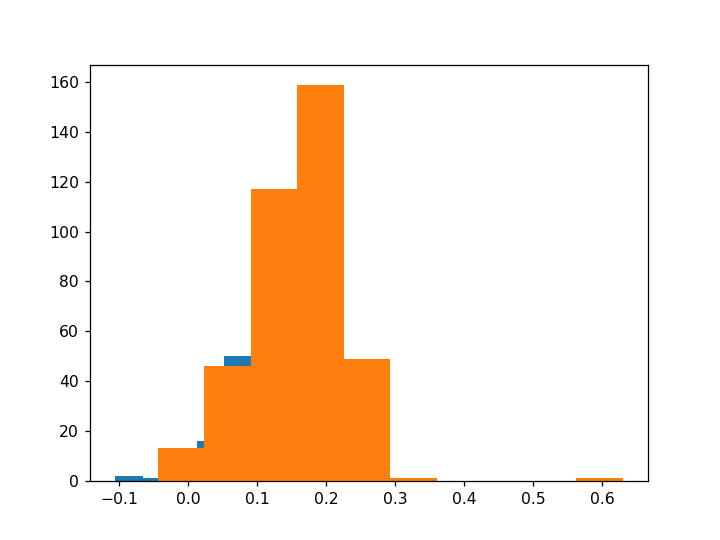

In [57]:
plt.hist(high_corrs)
plt.hist(low_corrs)
plt.show()









Batch 0


<IPython.core.display.Javascript object>


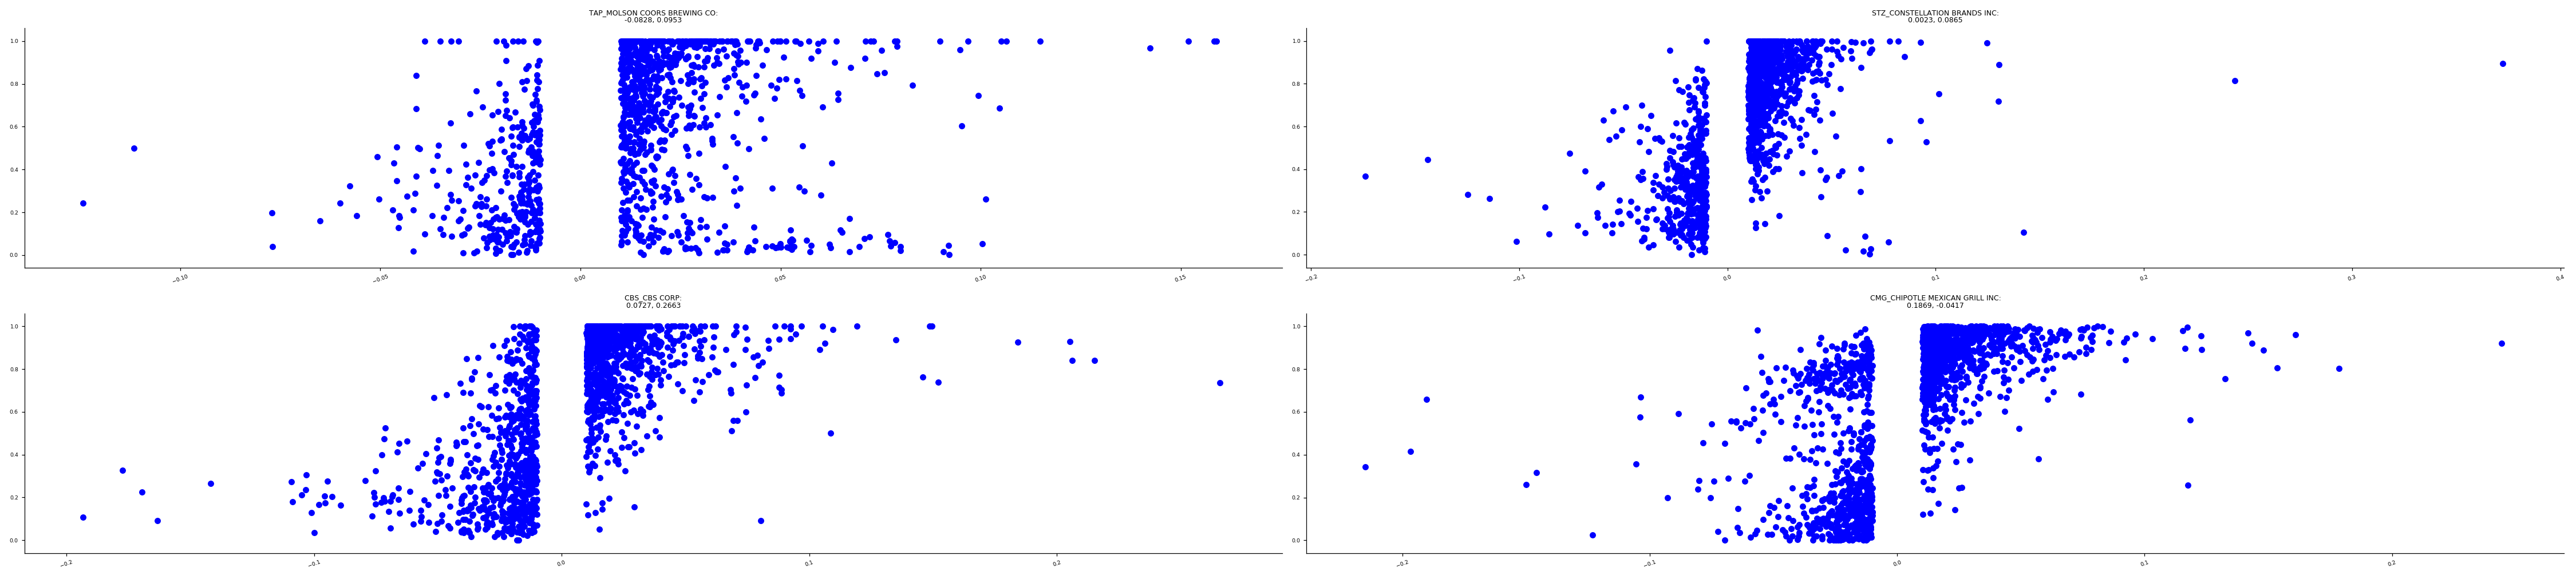

In [58]:
#sup_title_font =15
sub_title_font =8
legend_font =8
axis_font = 6
tick_rotation = 20

### matrix of subplots
n_cols = 2
n_rows = 2
n_plots = n_cols*n_rows
nloops = 1
temp_matrix = np.array(range(n_plots)).reshape(n_rows,n_cols)

for i in range(nloops):
    nn = len(df_price.columns)
    #print(lower, upper)
    temp_list = df_returns.columns[-n_plots:]
    print('\n\n\n\n\n\n\n\nBatch {}'.format(i))
    
    
    ####----PLOT THE FIGURES---------#####
    
    ### instantiage
    fig, ax = plt.subplots(n_rows,n_cols,figsize=(40,9))
    for k in range(n_rows):
        for l in range(n_cols):
            ## indices
            temp_idx = temp_matrix[k,l]
            symbol = temp_list[temp_idx]
             
            temp_corr = corrs[symbol]
            temp_color = []
            for value in temp_corr:
                if value <= 0.4:
                    temp_color.append('blue')
                elif value <= 0.7: 
                    temp_color.append('yellow')
                else:
                    temp_color.append('red')
               
            ### PLOT: Low Correlations 
            wm = ax[k,l].scatter(high_returns[symbol], bss_high_returns[symbol], 
                       color=temp_color[0])             
            ### PLOT: High Correlations 
            wm = ax[k,l].scatter(low_returns[symbol], bss_low_returns[symbol], 
                       color=temp_color[1])             
            
            ax[k,l].spines['top'].set_visible(False)
            ax[k,l].spines['right'].set_visible(False)
            ax[k,l].set_title('{}:\n{}, {}'.format(symbol, round(corrs[symbol][0], 4), round(corrs[symbol][1], 4)), fontsize=sub_title_font) 
            #ax[k,l].set_xlabel(fontsize=x_axis_font)
            ax[k,l].tick_params(axis="x", labelsize=axis_font, rotation=tick_rotation)
            ax[k,l].tick_params(axis="y", labelsize=axis_font)
            #ax[k,l].set_ylim([0.7, 1.02])            
         
            
            
    #fig.legend(bbox_to_anchor=(1.1, 1.1), prop={'size':15})
    #fig.suptitle('Daily Returns 2007-2018:\nBatch {}'.format(i), fontsize=sup_title_font)
    fig.subplots_adjust(hspace=0.7)
#     leg = fig.legend(temp_list_of_axis, labels=dot_labels, 
#                #title='Worst Trading Days', title_fontsize=25, 
#                bbox_to_anchor=(1.0, 0.97), 
#                prop={'size':legend_font})#, fontsize=sup_title_font)
#     leg.set_in_layout(False)
    #plt.tight_layout(pad=0.5, w_pad=5.0, h_pad=0.0)
    plt.tight_layout()
    plt.show()
    break